In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

# !pip install tensorflow==2.1.0
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, MaxPool1D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import np_utils

In [16]:
df = pd.read_csv('../input/nslkdd/kdd_train.csv')
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [17]:
le = LabelEncoder()

df['labels'] = le.fit_transform(df['labels'])
df['protocol_type'] = le.fit_transform(df['protocol_type'])
df['service'] = le.fit_transform(df['service'])
df['flag'] = le.fit_transform(df['flag'])

In [18]:
x = df.drop('labels', axis=1)
y = df.loc[:, ['labels']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.1, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = sc.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [19]:
y_train = np_utils.to_categorical(y_train)
y_train.shape

(113375, 23)

In [20]:
X_train.shape

(113375, 41)

In [21]:
def RFS(): 
    corr_matrix = combined_data.corr().abs().sort_values('labels')
    leastCorrelated = corr_matrix['labels'].where(lambda x: x < 0.005).dropna()
    leastCorrelated = list(leastCorrelated.index)

    leastSTD = combined_data.std().to_frame().where(lambda x: x < 0.05).dropna()#.nsmallest(20, columns=0)
    leastSTD = list(leastSTD.transpose().columns)

    featureElimination = set(leastCorrelated + leastSTD)
    return featureElimination

# Autoencoder

In [22]:
input_dim = X_train.shape[1]
encoding_dim = 32
ae_input_layer = Input(shape=(input_dim, ))

enc = Dense(64, activation="relu", activity_regularizer=regularizers.l1(10e-5))(ae_input_layer)
enc = BatchNormalization()(enc)
enc = Dropout(0.2)(enc)
enc = Dense(encoding_dim, activation="relu")(enc)

dec = Dense(64, activation="relu")(enc)
dec = BatchNormalization()(enc)
dec = Dropout(0.2)(dec)
dec = Dense(input_dim, activation="relu")(dec)

autoencoder = Model(inputs=ae_input_layer, outputs=dec)
encoder = Model(inputs=ae_input_layer, outputs=enc)

In [23]:
ae_epoch = 15
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [24]:
history = autoencoder.fit(X_train, X_train, 
                    epochs=ae_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Epoch 1/15
3543/3543 [==============================] - 8s 2ms/step - loss: 0.6441 - accuracy: 0.3969 - val_loss: 0.9824 - val_accuracy: 0.6419
Epoch 2/15
3543/3543 [==============================] - 7s 2ms/step - loss: 0.3830 - accuracy: 0.5468 - val_loss: 1.5027 - val_accuracy: 0.5792
Epoch 3/15
3543/3543 [==============================] - 7s 2ms/step - loss: 0.3567 - accuracy: 0.5490 - val_loss: 1.7271 - val_accuracy: 0.6802
Epoch 4/15
3543/3543 [==============================] - 7s 2ms/step - loss: 0.3364 - accuracy: 0.5486 - val_loss: 2.6176 - val_accuracy: 0.5432
Epoch 5/15
3543/3543 [==============================] - 7s 2ms/step - loss: 0.4441 - accuracy: 0.5535 - val_loss: 1.9979 - val_accuracy: 0.6394
Epoch 6/15
3543/3543 [==============================] - 7s 2ms/step - loss: 0.3855 - accuracy: 0.5485 - val_loss: 1.6745 - val_accuracy: 0.8647
Epoch 7/15
3543/3543 [==============================] - 7s 2ms/step - loss: 0.3828 - accuracy: 0.5547 - val_loss: 1.8285 - val_accuracy:

# Classifier + Autoencoder

In [25]:
encoder.trainable = False

input_layer = Input(shape=(input_dim, ))

encoding = encoder(input_layer, training=False)

layer1 = Dense(64, activation="relu")(encoding)
layer1 = BatchNormalization()(layer1)
layer1 = Dropout(0.2)(layer1)

layer2 = Dense(64, activation="relu")(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Dropout(0.3)(layer2)

layer3 = Dense(128, activation="relu")(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = Dropout(0.3)(layer3)

layer4 = Dense(128, activation="relu")(layer3)
layer4 = BatchNormalization()(layer4)
layer4 = Dropout(0.2)(layer4)

output_layer = Dense(23, activation="softmax")(layer4)

classifier = Model(inputs=input_layer ,outputs=output_layer)

In [26]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = classifier.fit(X_train, y_train,
                    epochs=10,
                    shuffle=True,
                    verbose=1).history

Epoch 1/10
3543/3543 [==============================] - 12s 3ms/step - loss: 0.3748 - accuracy: 0.9073
Epoch 2/10
3543/3543 [==============================] - 11s 3ms/step - loss: 0.1028 - accuracy: 0.9705
Epoch 3/10
3543/3543 [==============================] - 11s 3ms/step - loss: 0.0832 - accuracy: 0.9762
Epoch 4/10
3543/3543 [==============================] - 11s 3ms/step - loss: 0.0751 - accuracy: 0.9788
Epoch 5/10
3543/3543 [==============================] - 11s 3ms/step - loss: 0.0711 - accuracy: 0.9799
Epoch 6/10
3543/3543 [==============================] - 11s 3ms/step - loss: 0.0652 - accuracy: 0.9815
Epoch 7/10
3543/3543 [==============================] - 11s 3ms/step - loss: 0.0631 - accuracy: 0.9819
Epoch 8/10
3543/3543 [==============================] - 11s 3ms/step - loss: 0.0590 - accuracy: 0.9833
Epoch 9/10
3543/3543 [==============================] - 11s 3ms/step - loss: 0.0574 - accuracy: 0.9837
Epoch 10/10
3543/3543 [==============================] - 11s 3ms/step - l

['protocol_type', 'service', 'flag']
['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'binary_type']


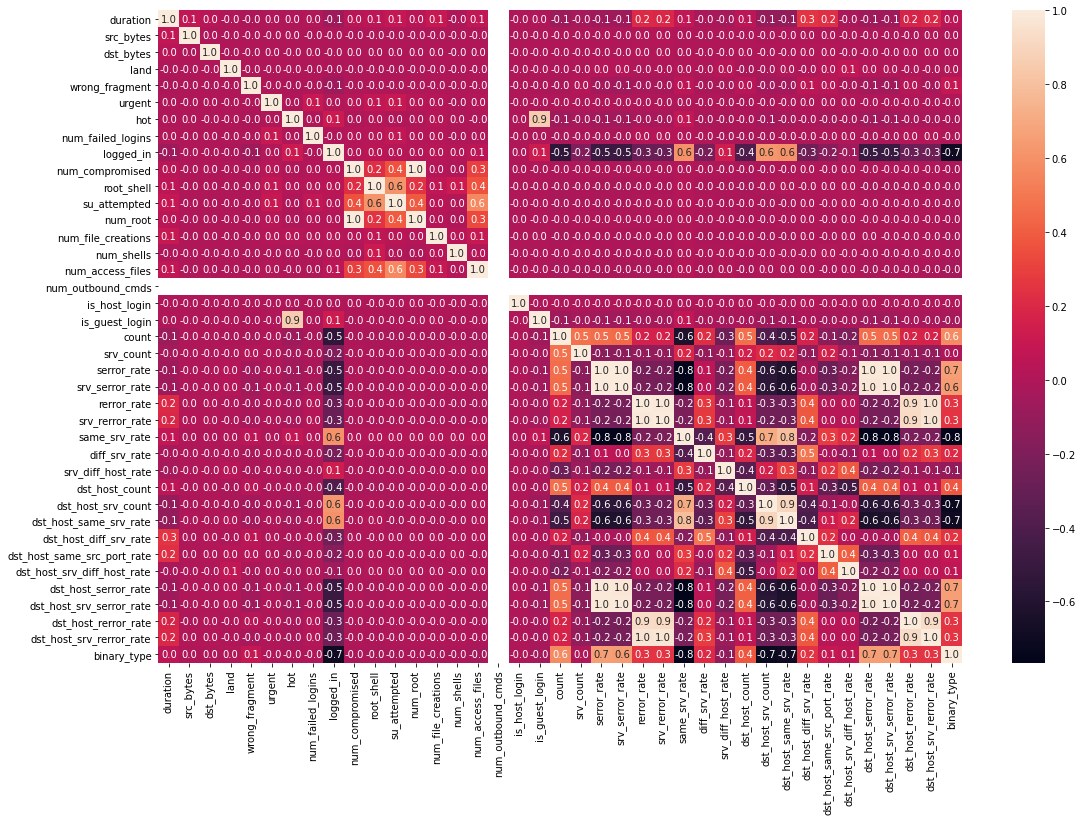

In [79]:
plt.figure(figsize=(18,12));
sns.heatmap(train_df.corr(), annot=True, fmt='1.1f');

<113375x23 sparse matrix of type '<class 'numpy.float64'>'
	with 113375 stored elements in Compressed Sparse Row format>

In [84]:
def create_model_bin(n_inputs):

    inputs = keras.Input(shape=(n_inputs,), name="input")
    batch = layers.BatchNormalization()(inputs)
    layer1 = layers.Dense(256, activation="sigmoid", name="dense1")(batch)
    drop = layers.Dropout(0.5)(layer1)
    layer11 = layers.Dense(56, activation="relu", name="dense3")(drop)
    drop = layers.Dropout(0.5)(layer11)
    layer2 = layers.Dense(256, activation="sigmoid", name="dense2")(drop)
    batch = layers.BatchNormalization()(layer2)
    outputs = layers.Dense(1, activation="sigmoid", name="out")(batch)

    return keras.Model(inputs=inputs, outputs=outputs)

In [53]:
import keras.backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [40]:
bin_model = create_model_bin(122)
bin_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 122)]             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 122)               488       
_________________________________________________________________
dense1 (Dense)               (None, 256)               31488     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense3 (Dense)               (None, 56)                14392     
_________________________________________________________________
dropout_5 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense2 (Dense)               (None, 256)               1459

In [41]:
bin_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer="adam", 
               metrics=['accuracy', precision, recall])

In [188]:
history = bin_model.fit(x_train, y_train_bin, batch_size=100, epochs=10)

Epoch 1/10
1134/1134 [==============================] - 5s 3ms/step - loss: 0.1286 - accuracy: 0.9422 - precision: 0.9413 - recall: 0.9331
Epoch 2/10
1134/1134 [==============================] - 4s 3ms/step - loss: 6.6073e-04 - accuracy: 0.9998 - precision: 0.9998 - recall: 0.9998
Epoch 3/10
1134/1134 [==============================] - 4s 3ms/step - loss: 2.8355e-04 - accuracy: 0.9999 - precision: 0.9999 - recall: 1.0000
Epoch 4/10
1134/1134 [==============================] - 4s 3ms/step - loss: 7.7395e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 5/10
1134/1134 [==============================] - 4s 3ms/step - loss: 1.6706e-04 - accuracy: 0.9999 - precision: 0.9999 - recall: 1.0000
Epoch 6/10
1134/1134 [==============================] - 4s 3ms/step - loss: 2.1743e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 7/10
1134/1134 [==============================] - 4s 3ms/step - loss: 3.5246e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epo

In [195]:
bin_model.evaluate(x_test, y_test_bin)

394/394 [==============================] - 0s 971us/step - loss: 36640.3438 - accuracy: 0.4301 - precision: 0.4471 - recall: 0.9179


[36640.34375, 0.4300682544708252, 0.44709545373916626, 0.9178646206855774]

In [89]:
def create_model_multi(n_inputs):

    model1=Sequential()
    
    model1.add(Input(shape=(n_inputs,), name="input"))
    model1.add(BatchNormalization())
    
    model1.add(Conv1D(180,2, activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPool1D(2))
    model1.add(Dropout(0.2))

    model1.add(Conv1D(300,2, activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPool1D(2))
    model1.add(Dropout(0.4))

    model1.add(Flatten())
    model1.add(Dense(256, activation='relu'))
    model1.add(Dropout(0.4))

    model1.add(Dense(23),activation='softmax')

    return model1

In [90]:
multi_model = create_model_bin(122)
multi_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 122)]             0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 122)               488       
_________________________________________________________________
dense1 (Dense)               (None, 256)               31488     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense3 (Dense)               (None, 56)                14392     
_________________________________________________________________
dropout_17 (Dropout)         (None, 56)                0         
_________________________________________________________________
dense2 (Dense)               (None, 256)               1459

In [92]:
multi_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer="adam", 
               metrics=['accuracy'])

In [98]:
from scipy.sparse import csr_matrix
y_train_multi_d = csr_matrix(y_train_multi)
y_train_multi_d.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
history = multi_model.fit(x_train, y_train_multi_d, batch_size=100, epochs=10)

Epoch 1/10


TypeError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:152 __call__
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:254 call  **
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/losses_utils.py:137 squeeze_or_expand_dimensions
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/losses_utils.py:66 remove_squeezable_dimensions
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1405 convert_to_tensor_v2_with_dispatch
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1415 convert_to_tensor_v2
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1540 convert_to_tensor
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:265 constant
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:283 _constant_impl
        
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:553 make_tensor_proto
        

    TypeError: Failed to convert object of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> to Tensor. Contents: SparseTensor(indices=Tensor("DeserializeSparse:0", shape=(None, 2), dtype=int64), values=Tensor("DeserializeSparse:1", shape=(None,), dtype=float32), dense_shape=Tensor("stack:0", shape=(2,), dtype=int64)). Consider casting elements to a supported type.


In [194]:
bin_model.evaluate(x_test, y_test_multi)

394/394 [==============================] - 0s 994us/step - loss: -697422.6875 - accuracy: 0.0071 - precision: 1.0000 - recall: 0.9684


[-697422.6875, 0.007143991068005562, 1.0, 0.968436598777771]